# Deep Colaborative Filtering using Skorch
This notebook follows the steps required to build and train a neural network for the purpose of collaborative filtering, using the [MovieLens](https://grouplens.org/datasets/movielens/latest/) data set.   

The neural network will be built using the [PyTorch](https://pytorch.org/) framework, with the [Skorch library](https://github.com/dnouri/skorch) being used to make training and testing the model simple.

## Load data

In [16]:
import numpy as np
import pandas as pd
from interactions_data import create_index
from sklearn.model_selection import train_test_split

In [17]:
path = 'data/movielens-small/'

In [18]:
df = pd.read_csv(path+'ratings.csv').drop('timestamp', axis=1)

In [19]:
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [20]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()
max_score = max(df.rating)
min_score = min(df.rating)

In [21]:
print("Number of users:", n_users) 
print("Number of movies:", n_items)
print("Ratings range between", min_score, "and", max_score)

Number of users: 610
Number of movies: 9724
Ratings range between 0.5 and 5.0


### Encode IDs from 0-n
The users and movies in the data set all have unique IDs, but the values of these IDs do not all fall in one sequential range from 0 up to the total number of users/movies.   

Since there will be an embedding layer in the neural network, the user and movie IDs need to reset to all fall between 0 and the total number of users and movies respectively.

In [22]:
# sort IDs
movie_ids = np.sort(df.movieId.unique())
user_ids = np.sort(df.userId.unique())

In [23]:
# use the custom create_index function to reset IDs
??create_index

Signature: create_index(data, start=0)
Source:   
def create_index(data, start=0):

    """
    Creates a sequential mapping for a list of unique IDs.

    ...

    Parameters
    ----------
    data : array-like
        list or array of unique IDs to be encoded sequentially

    Returns
    -------
    encoder : dictionary
        mapping from original data to index

    decoder : dictionary
        mapping from index to original data
    """

    encoder = {}
    decoder = {}

    idx = start
    for item in data:

        if item not in encoder.keys():
            encoder[item] = idx
            decoder[idx] = item
            idx += 1

    return encoder, decoder
File:      d:\myfiles\google drive\classwork\dissertation\deep-collaborative-filtering\interactions_data.py
Type:      function


In [24]:
movie_encoder, movie_decoder = create_index(movie_ids)
user_encoder, user_decoder = create_index(user_ids)

In [25]:
df.movieId = df.movieId.replace(movie_encoder)
df.userId = df.userId.replace(user_encoder)

In [29]:
print("Max user ID:", max(df.userId.unique()))
print("Max movie ID:", max(df.movieId.unique()))

Max user ID: 609
Max movie ID: 9723


There are a total of 610 users, who now each have a unique ID between 0 and 609, and similarly the movies now all have IDs between 0 and 9723.

### Create test set
The next step is to split the data into train and test sets. A ratio of 80:20 will be used in this example.   

First, the data is separated into features (user Ids, movie Ids) and targets (ratings).

In [30]:
X = df.iloc[:,:2].values
y = df.iloc[:,2].values
y = y.astype('float32')

Then, the features and targets are separated into train and test sets.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=X[:,0])

In [32]:
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [33]:
X_train.shape, y_train.shape

((80668, 2), (80668, 1))

## Neural network
The next step is to create the neural network, using the PyTorch framework.   

This neural network will be pretty simple, with the input being simply a user-movie pair, and the output being a predicted rating.
Between the input and the output, we have two layers:   
  - embedding layer (with dropout)
  - hidden layer (with dropout and relu activation function)   
  
![Architecture](https://github.com/James-Leslie/Netflix-Recommender-System/blob/master/diagrams/EmbeddingNet.png?raw=true)   

The architecture shown above is very similar to that of a standard feed-forward neural network, with one significant difference.   

Each User and Movie ID will have a set of embeddings which can be 'learned' through training.   
Only when observations with that particular User or Movie ID are fed through the network, will the network activate (and update) the mapped embeddings.   
In other words, User1 and User2 will have different values for the nodes in the first layer. When passing ratings made my User1 into the network, then only User1's embedding layer will be trained.   
Similarly, when ratings for Movie1 are passed into the network, then only the movie embeddings associated to that movie will be updated through training.   

The hidden layer of the network is fully connected to the embedding layer, and thus will always be updated in any training batch.   

Finally, a scaled sigmoid activation function is used to squeeze the outputs between 0.5 and 5.0.

In [34]:
import torch
from torch import nn
import torch.nn.functional as F
from time import time

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

In [37]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.min_score, self.max_score = min_score, max_score

        # get user and item embeddings
        (self.u, self.i) = [get_emb(*o) for o in [
            (n_users, 10), (n_items, 10)]]
        self.lin1 = nn.Linear(20, 10)  # 10 hidden neurons
        self.lin2 = nn.Linear(10, 1)
        self.drop1 = nn.Dropout(0.05)  # dropout rate of 5%
        self.drop2 = nn.Dropout(0.15)  # dropout rate of 15%

    def forward(self, X, **kwargs):
        users, items = X[:,0], X[:,1]
        # concatenate embeddings to form first layer, add dropout
        x = self.drop1(torch.cat([self.u(users),self.i(items)], dim=1))
        # second layer with 10 hidden neurons and dropout
        x = self.drop2(F.relu(self.lin1(x)))
        # output layer with one neuron
        x = self.lin2(x)
        # add sigmoid activation function, but squeeze between min and max score
        return torch.sigmoid(x) * (self.max_score - self.min_score) + self.min_score

### Training using Skorch
The skorch library makes it easy to train the model, in a similar manner to Sk Learn models.

In [38]:
from skorch import NeuralNetRegressor

In [39]:
net = NeuralNetRegressor(
    EmbeddingNet,
    max_epochs=10,
    lr=0.1,
    device=device,
)

In [40]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0516        0.9543  2.7093
      2        0.8976        0.8438  2.5422
      3        0.8140        0.8050  2.4913
      4        0.7750        0.7945  2.5662
      5        0.7519        0.7962  2.6220
      6        0.7358        0.8128  2.5532
      7        0.7271        0.8147  2.5562
      8        0.7188        0.8159  2.5721
      9        0.7146        0.7942  2.5512
     10        0.7086        0.8101  2.5642


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=EmbeddingNet(
    (u): Embedding(610, 10)
    (i): Embedding(9724, 10)
    (lin1): Linear(in_features=20, out_features=10, bias=True)
    (lin2): Linear(in_features=10, out_features=1, bias=True)
    (drop1): Dropout(p=0.05)
    (drop2): Dropout(p=0.15)
  ),
)

### Test on unseen data
The RMSE score on the test set for this model is 0.886, which is better than the best performance (0.91) achieved by the [Librec System](https://www.librec.net/release/v1.3/example.html) for collaborative filtering.

In [43]:
preds = net.predict(X_test)

In [44]:
import seaborn as sns

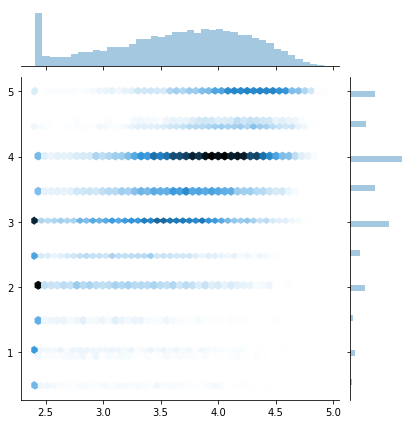

In [49]:
sns.jointplot(preds, y_test, kind='hex', stat_func=None);

In [50]:
np.sqrt(np.mean((preds - y_test) ** 2))

0.8860589